In [25]:
import numpy as np
import gym 
import tensorflow as tf
import tf_slim as slim
from collections import deque,Counter 
import random 
from datetime import datetime 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [26]:
color=np.array([210,164,74]).mean()

def preprocess_observation(observation):
    #crop
    image=observation[1:176:2,::2]
    #convert the image to grayscale
    image=image.mean(axis=2)
    #to increase the image contrast
    image[image==color]=0
    image=(image-128)/127
    
    return image.reshape(88,80,1)

In [27]:
environment=gym.make("MsPacman-v0")
n_outputs=environment.action_space.n
print('No of possible moves in the Pacman game is {}'.format(n_outputs))
print("Those moves are:")
moves_meaning=environment.env.get_action_meanings()
i=1
for move in moves_meaning:
    print("\t{0}:{1}".format(i,move))
    i+=1

No of possible moves in the Pacman game is 9
Those moves are:
	1:NOOP
	2:UP
	3:RIGHT
	4:LEFT
	5:DOWN
	6:UPRIGHT
	7:UPLEFT
	8:DOWNRIGHT
	9:DOWNLEFT


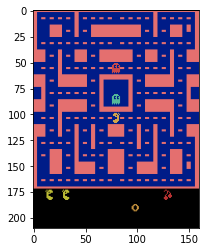

In [28]:
observation=environment.reset()
for j in range(22):
    if j>20:
        plt.imshow(observation)
        plt.show()
        
    observation,_, _, _=environment.step(1)
    

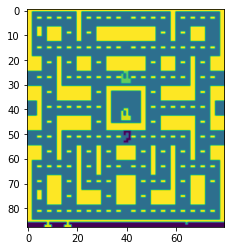

In [29]:
observation_preporcessed=preprocess_observation(observation).reshape(88,80)
plt.imshow(observation_preporcessed)
plt.show()

In [42]:
def q_network(X,name_scope):
    initializer = tf.keras.initializers.VarianceScaling(scale=2.0)
    
    with tf.compat.v1.variable_scope(name_scope) as scope:
        layer_1=slim.conv2d(X,num_outputs=64,kernel_size=(8,8),stride=4,padding='SAME',weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_1',layer_1)
        
        layer_2=slim.conv2d(layer_1,num_outputs=64,kernel_size=(4,4),stride=2,padding='SAME',weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_2',layer_2)
        
        layer_3=slim.conv2d(layer_2,num_outputs=64,kernel_size=(3,3),stride=1,padding='SAME',weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_3',layer_3)
        
        flaten=slim.flatten(layer_3)
        fully_connected=slim.fully_connected(flaten,num_outputs=128,weights_initializer=initializer)
        tf.compat.v1.summary.histogram('fully_connected',fully_connected)
        output=slim.fully_connected(fully_connected,num_outputs=n_outputs,activation_fn=None,weights_initializer=initializer)
        tf.compat.v1.summary.histogram('output',output)
        
        vars={v.name[len(scope.name):]: v for v in tf.compat.v1.get_collection(key=tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)}
        
        return vars,output

In [43]:
epsilon=0.5
epsilon_max=1.0
epsilon_min=0.05
epsilon_decay_steps=500000

def epsilon_greedy(action,step):
    p=np.random.random(1).squeeze()
    epsilon=max(epsilon_min,epsilon_max-(epsilon_max-epsilon_min)*step/epsilon_decay_steps)
    if np.random.rand()<epsilon:
        return np.random.randint(n_outputs)
    else:
        return action

In [44]:
buffer_len=20000
exp_buffer=deque(maxlen=buffer_len)

def sample_memories(batc_size):
    parm_batch=np.random.permutation(len(exp_buffer))[:batc_size]
    mem=np.array(exp_buffer)[perm_batch]
    return men[:,0],men[:,1],men[:,2],men[:,3],men[:,4]

In [45]:
num_episodes=3000
batch_size=512
input_shape=(None,88,80,1)
learning_rate=0.001
x_shape=(None,88,80,1)
discount_factor=0.97

global_step=0
copy_steps=100
steps_train=4
start_steps=2000

In [46]:
log_dir="logs"
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
X = tf.compat.v1.placeholder(tf.float32, shape=x_shape)
in_training_mode = tf.compat.v1.placeholder(tf.bool)

In [47]:
mainQ,mainQ_outputs=q_network(X,'mainQ')
targetQ,targetQ_outputs=q_network(X,'targetQ')